# Gender Convergence in Household Work: A 20-Year Analysis (2002–2022)

This notebook tests three hypotheses about gender convergence in household work and egalitarian attitudes using harmonized ISSP data.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, pearsonr, spearmanr, linregress, sem
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

os.chdir('../')
from tueplots import bundles
from tueplots import figsizes, fontsizes
plt.rcParams.update(bundles.icml2024())
USE_TUEPLOTS = True

COLOR_PALETTE = {
    'Male': '#56B4E9',
    'Female': '#f678a7',
    'neutral': '#029E73'
}

In [2]:
# ICML-like matplotlib defaults for one-column figures
# Sets figure size, fonts, line widths, and savefig options so plots are suitable for two-column papers (one-column width)
import matplotlib as mpl

mpl.rcParams.update({
    "figure.figsize": (3.25, 2.2),   # inches: ~1 column width
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.01,

    "font.size": 8,                  # base text size
    "axes.titlesize": 9,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "legend.title_fontsize": 7,

    "lines.linewidth": 1.0,
    "axes.linewidth": 0.8,
})

# Recommended usage when creating figures in this notebook:
# fig, ax = plt.subplots(constrained_layout=True)  # helps prevent label/caption mismatch
# ax.legend(frameon=False, ncol=1, handlelength=1.2, borderaxespad=0.2, labelspacing=0.2)
# Prefer saving as PDF for LaTeX inclusion: fig.savefig("fig.pdf")


In [3]:
data_frames = []
for year in [2002, 2012, 2022]:
    df = pd.read_csv(f'data/final_csv/{year}.csv')
    df['year'] = year
    data_frames.append(df)

df_all = pd.concat(data_frames, ignore_index=True)
print(f"Loaded {len(df_all):,} observations across {len(df_all['year'].unique())} years")

Loaded 154,154 observations across 3 years


In [4]:
# Clean and standardize key variables
df_all['eg_score_norm'] = pd.to_numeric(
    df_all['eg_score_norm'].astype(str).str.replace(',', '.', regex=False),
    errors='coerce'
)

numeric_vars = ['hh_wrk_hrs', 'SP_HH', 'HOMPOP', 'age', 'wrk_hrs', 'SPWRKHRS']
for var in numeric_vars:
    if var in df_all.columns:
        df_all[var] = pd.to_numeric(
            df_all[var].astype(str).str.replace(',', '.', regex=False),
            errors='coerce'
        )

df_all['sex'] = df_all['sex'].astype(str).str.strip().str.title()

if 'country' in df_all.columns:
    df_all['country'] = df_all['country'].astype(str).str.strip().str.upper()
elif 'COUNTRY' in df_all.columns:
    df_all['country'] = df_all['COUNTRY'].astype(str).str.strip().str.upper()

In [5]:
analysis_data = df_all[
    (df_all['sex'].isin(['Male', 'Female'])) &
    (df_all['hh_wrk_hrs'].notna()) &
    (df_all['SP_HH'].notna()) &
    (df_all['eg_score_norm'].notna())
].copy()

print(f"Analysis sample: N = {len(analysis_data):,}")
for year in [2002, 2012, 2022]:
    n = len(analysis_data[analysis_data['year'] == year])
    n_male = len(analysis_data[(analysis_data['year'] == year) & (analysis_data['sex'] == 'Male')])
    n_female = len(analysis_data[(analysis_data['year'] == year) & (analysis_data['sex'] == 'Female')])
    print(f"{year}: n={n:,} (M={n_male:,}, F={n_female:,})")

Analysis sample: N = 88,214
2002: n=27,677 (M=12,660, F=15,017)
2012: n=34,860 (M=17,102, F=17,758)
2022: n=25,677 (M=12,364, F=13,313)


## 3. H1: Convergence of Male and Female Household Work

**Research Question:** Have household work hours become more equal between genders over time?

**Estimand:** Gender gap in household work hours = E[hours|Female] - E[hours|Male]

**H₀:** No significant change in gender gap over time (β_time = 0)

**H₁:** Gender gap decreases significantly over time (β_time < 0)

In [6]:
h1_results = []

for year in [2002, 2012, 2022]:
    year_data = analysis_data[analysis_data['year'] == year]
    
    male_hrs = year_data[year_data['sex'] == 'Male']['hh_wrk_hrs'].dropna()
    female_hrs = year_data[year_data['sex'] == 'Female']['hh_wrk_hrs'].dropna()
    
    male_mean, male_std = male_hrs.mean(), male_hrs.std()
    female_mean, female_std = female_hrs.mean(), female_hrs.std()
    male_se = sem(male_hrs)
    female_se = sem(female_hrs)
    
    gap = female_mean - male_mean
    gap_se = np.sqrt(male_se**2 + female_se**2)
    gap_ci = (gap - 1.96*gap_se, gap + 1.96*gap_se)
    
    t_stat, p_value = ttest_ind(female_hrs, male_hrs)
    
    pooled_std = np.sqrt(((len(male_hrs)-1)*male_std**2 + (len(female_hrs)-1)*female_std**2) / 
                         (len(male_hrs) + len(female_hrs) - 2))
    cohens_d = gap / pooled_std
    
    h1_results.append({
        'Year': year,
        'Male_Mean': male_mean,
        'Male_SE': male_se,
        'Female_Mean': female_mean,
        'Female_SE': female_se,
        'Gap': gap,
        'Gap_CI_Lower': gap_ci[0],
        'Gap_CI_Upper': gap_ci[1],
        'T_Stat': t_stat,
        'P_Value': p_value,
        'Cohens_D': cohens_d,
        'N_Male': len(male_hrs),
        'N_Female': len(female_hrs)
    })

h1_df = pd.DataFrame(h1_results)
print("H1: Gender gap in household work hours")
print(h1_df[['Year', 'Male_Mean', 'Female_Mean', 'Gap', 'Gap_CI_Lower', 'Gap_CI_Upper', 'P_Value', 'Cohens_D']].to_string(index=False))

H1: Gender gap in household work hours
 Year  Male_Mean  Female_Mean       Gap  Gap_CI_Lower  Gap_CI_Upper  P_Value  Cohens_D
 2002   9.008136    21.200240 12.192104     11.880852     12.503356      0.0  0.894870
 2012  10.388259    19.815013  9.426754      9.154106      9.699403      0.0  0.721781
 2022  11.086542    17.336513  6.249972      5.947709      6.552234      0.0  0.501437


In [7]:
years = h1_df['Year'].values
gaps = h1_df['Gap'].values

slope, intercept, r_value, p_value, std_err = linregress(years, gaps)

print("Linear trend test:")
print(f"Gap = {slope:.4f} × Year + {intercept:.2f}")
print(f"Slope: {slope:.4f} hrs/year (SE = {std_err:.4f}), R² = {r_value**2:.4f}, p = {p_value:.4f}")

if p_value < 0.05:
    direction = "decreasing" if slope < 0 else "increasing"
    print(f"Result: Significant {direction} trend")
else:
    print("Result: No significant trend - gap stable over 20 years")

Linear trend test:
Gap = -0.2971 × Year + 607.07
Slope: -0.2971 hrs/year (SE = 0.0119), R² = 0.9984, p = 0.0254
Result: Significant decreasing trend


In [8]:
analysis_data['female'] = (analysis_data['sex'] == 'Female').astype(int)
analysis_data['year_centered'] = analysis_data['year'] - 2002

model_h1 = ols('hh_wrk_hrs ~ female * year_centered', data=analysis_data).fit(cov_type='HC3')

print("Regression: Gender × Time interaction")
print(model_h1.summary().tables[1])

interaction_p = model_h1.pvalues['female:year_centered']
if interaction_p < 0.05:
    print(f"Result: Significant convergence (p={interaction_p:.4f})")
else:
    print(f"Result: No convergence (p={interaction_p:.4f})")

Regression: Gender × Time interaction
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                9.1449      0.083    110.458      0.000       8.983       9.307
female                  12.2537      0.142     86.133      0.000      11.975      12.533
year_centered            0.1041      0.007     15.649      0.000       0.091       0.117
female:year_centered    -0.2960      0.011    -26.702      0.000      -0.318      -0.274
Result: Significant convergence (p=0.0000)
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                9.1449      0.083    110.458      0.000       8.983       9.307
female                  12.2537      0.142     86.133      0.000      11.975      12.533
year_centered            0.10

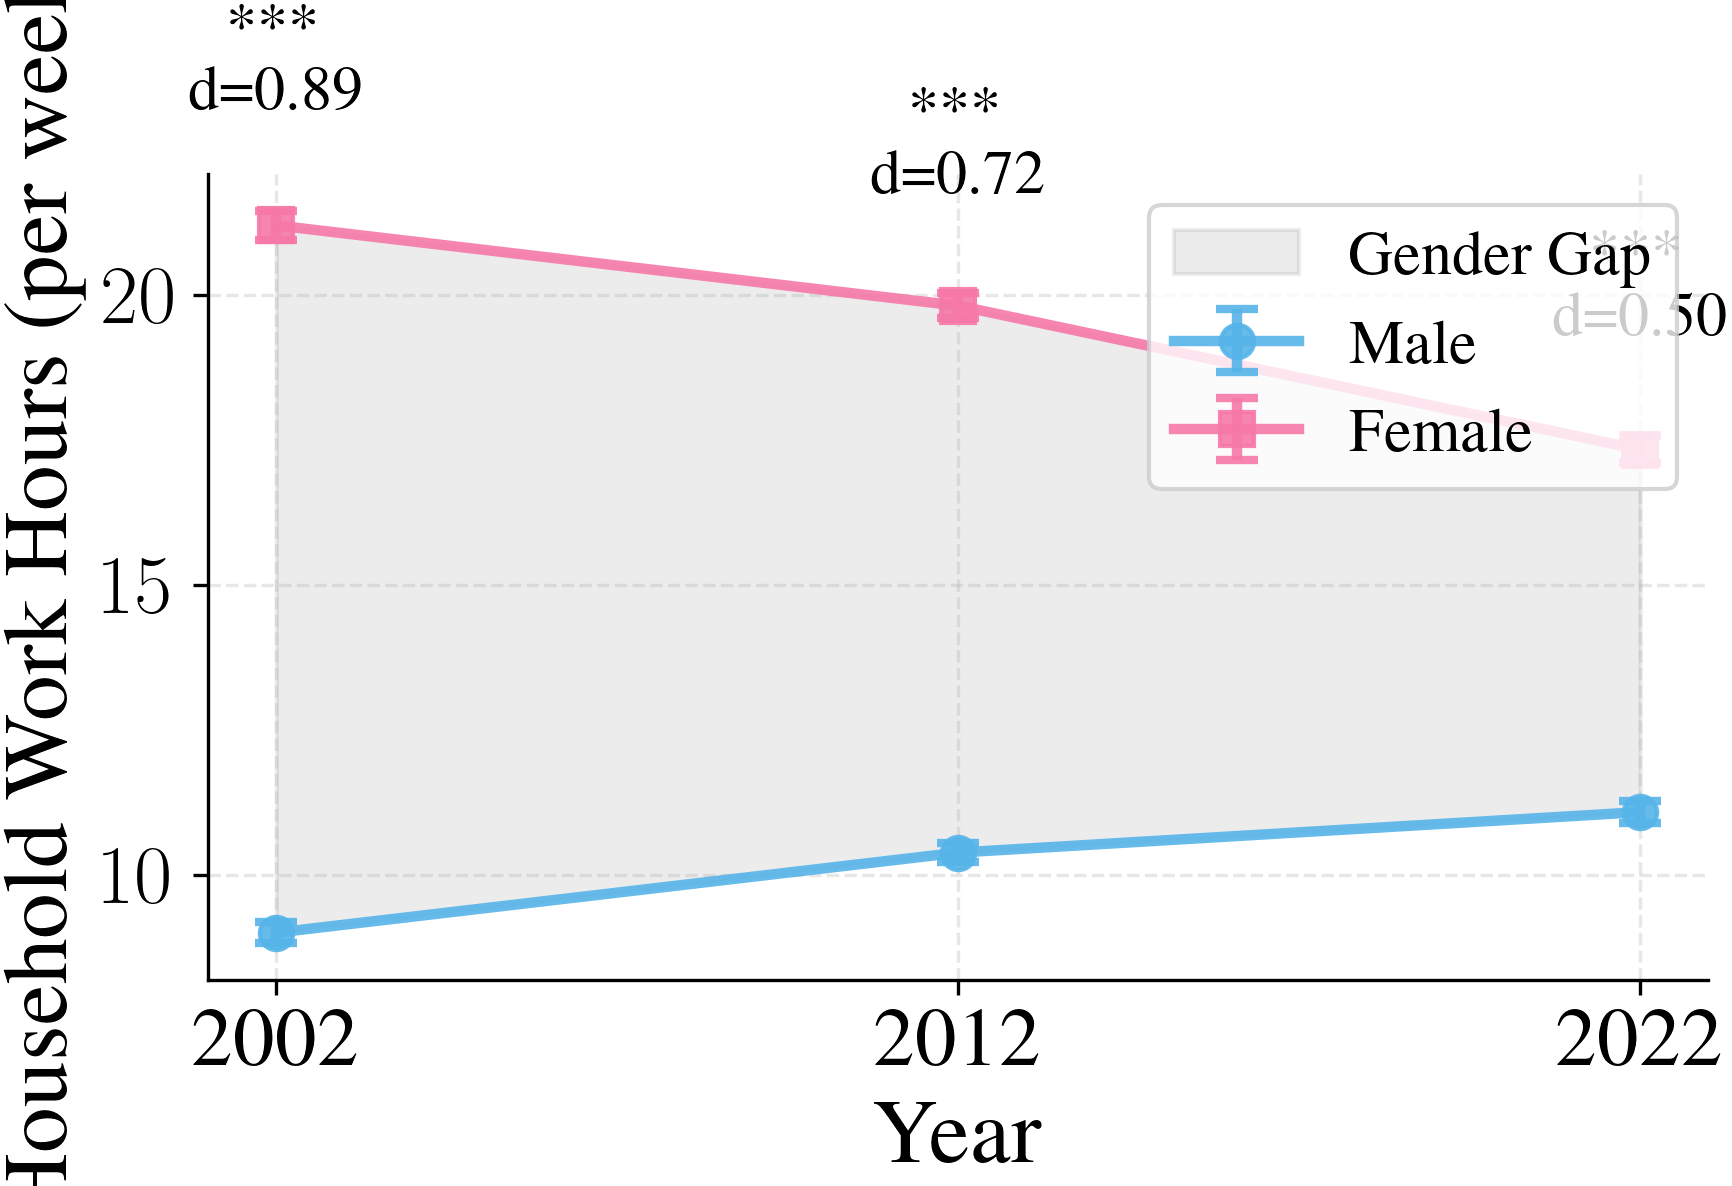

In [9]:
if USE_TUEPLOTS:
    plt.rcParams.update(bundles.icml2024())
    plt.rcParams.update(figsizes.icml2024_half(nrows=1, ncols=1))

fig, ax = plt.subplots(figsize=(6, 4.2))

years = h1_df['Year'].values
male_means = h1_df['Male_Mean'].values
female_means = h1_df['Female_Mean'].values
male_ses = h1_df['Male_SE'].values
female_ses = h1_df['Female_SE'].values

ax.errorbar(years, male_means, yerr=1.96*male_ses, 
            marker='o', markersize=8, linewidth=2.5, capsize=5, capthick=2,
            color=COLOR_PALETTE['Male'], label='Male', alpha=0.9)

ax.errorbar(years, female_means, yerr=1.96*female_ses,
            marker='s', markersize=8, linewidth=2.5, capsize=5, capthick=2,
            color=COLOR_PALETTE['Female'], label='Female', alpha=0.9)

ax.fill_between(years, male_means, female_means, alpha=0.15, color='gray', label='Gender Gap')

for idx, row in h1_df.iterrows():
    y_pos = max(row['Female_Mean'] + 1.96*row['Female_SE'], row['Male_Mean'] + 1.96*row['Male_SE']) + 1.5
    sig = '***' if row['P_Value'] < 0.001 else '**' if row['P_Value'] < 0.01 else '*' if row['P_Value'] < 0.05 else 'ns'
    ax.text(row['Year'], y_pos, f"{sig}\nd={row['Cohens_D']:.2f}", 
            ha='center', va='bottom', fontsize=15, fontweight='bold')

ax.set_xlabel('Year', fontsize=22)
ax.set_ylabel('Household Work Hours (per week)', fontsize=22)
ax.legend(frameon=True, loc='upper right', fontsize=15)
ax.set_xticks([2002, 2012, 2022])
ax.set_xticklabels(['2002', '2012', '2022'], fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
os.makedirs('assets/images/statistical', exist_ok=True)
plt.savefig('assets/images/statistical/h1_convergence_clean.pdf', dpi=300, bbox_inches='tight')
plt.savefig('assets/images/statistical/h1_convergence_clean.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. H2: Egalitarian Views vs Household Work

**Research Question:** Do egalitarian attitudes align with egalitarian household behaviors?

**Conditional Logic:**
- If H1 shows convergence → test whether attitudes explain the change
- If H1 shows no convergence → test whether attitudes change despite stable behavior (norm-behavior divergence)

**Approach:**
- Construct gender-aware equity metric: **male's share of household work**
  - Standardized across both genders for consistent interpretation
  - Higher values = men doing more HH work = more egalitarian
  - Aligns with Equality score direction
- Test correlation between egalitarian attitudes and equitable behavior
- Stratify by gender to identify differences


In [10]:
def calculate_equity(row):
    total_hrs = row['hh_wrk_hrs'] + row['SP_HH']
    if total_hrs == 0 or pd.isna(total_hrs):
        return np.nan
    
    if row['sex'] == 'Male':
        return row['hh_wrk_hrs'] / total_hrs
    else:
        return row['SP_HH'] / total_hrs

analysis_data['equity_metric'] = analysis_data.apply(calculate_equity, axis=1)
analysis_data['equity_metric'] = analysis_data['equity_metric'].clip(0, 1)

print("Equity metric: Male's share of HH work")
print("0.5 = equal split, >0.5 = male does more (egalitarian), <0.5 = female does more (traditional)")

for sex in ['Male', 'Female']:
    sex_data = analysis_data[analysis_data['sex'] == sex]['equity_metric'].dropna()
    print(f"{sex} respondents: mean={sex_data.mean():.3f}, "
          f"{(sex_data < 0.5).sum() / len(sex_data) * 100:.1f}% traditional, "
          f"{(sex_data > 0.5).sum() / len(sex_data) * 100:.1f}% egalitarian")

Equity metric: Male's share of HH work
0.5 = equal split, >0.5 = male does more (egalitarian), <0.5 = female does more (traditional)
Male respondents: mean=0.349, 68.8% traditional, 12.7% egalitarian
Female respondents: mean=0.288, 78.4% traditional, 7.6% egalitarian


In [11]:
h2_data = analysis_data[['year', 'sex', 'eg_score_norm', 'equity_metric']].dropna()
h2_results = []

for year in [2002, 2012, 2022]:
    year_data = h2_data[h2_data['year'] == year]
    
    pearson_r, pearson_p = pearsonr(year_data['eg_score_norm'], year_data['equity_metric'])
    spearman_r, spearman_p = spearmanr(year_data['eg_score_norm'], year_data['equity_metric'])
    
    X = year_data['eg_score_norm'].values.reshape(-1, 1)
    y = year_data['equity_metric'].values
    model = LinearRegression()
    model.fit(X, y)
    r_squared = model.score(X, y)
    slope = model.coef_[0]
    
    h2_results.append({
        'Year': year,
        'N': len(year_data),
        'Pearson_r': pearson_r,
        'Pearson_p': pearson_p,
        'Spearman_ρ': spearman_r,
        'Spearman_p': spearman_p,
        'R²': r_squared,
        'Slope': slope
    })

h2_df = pd.DataFrame(h2_results)
print("H2: Attitude-behavior alignment")
print(h2_df.to_string(index=False))
print(f"Average correlation: r={h2_df['Pearson_r'].mean():.3f}, R²={h2_df['R²'].mean():.3f}")

H2: Attitude-behavior alignment
 Year     N  Pearson_r    Pearson_p  Spearman_ρ    Spearman_p       R²    Slope
 2002 27446   0.108352 1.856787e-72    0.129342 1.069569e-102 0.011740 0.104649
 2012 34676   0.096773 6.299565e-73    0.117135 3.467954e-106 0.009365 0.098729
 2022 25589   0.107631 8.405672e-67    0.121886  2.810973e-85 0.011584 0.096109
Average correlation: r=0.104, R²=0.011


In [12]:
def fishers_z_test(r1, n1, r2, n2):
    z1 = 0.5 * np.log((1 + r1) / (1 - r1))
    z2 = 0.5 * np.log((1 + r2) / (1 - r2))
    se = np.sqrt(1/(n1-3) + 1/(n2-3))
    z_stat = (z1 - z2) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    return z_stat, p_value

gender_results = []

for year in [2002, 2012, 2022]:
    year_data = h2_data[h2_data['year'] == year]
    
    male_data = year_data[year_data['sex'] == 'Male']
    male_r, male_p = pearsonr(male_data['eg_score_norm'], male_data['equity_metric'])
    
    female_data = year_data[year_data['sex'] == 'Female']
    female_r, female_p = pearsonr(female_data['eg_score_norm'], female_data['equity_metric'])
    
    z_stat, p_diff = fishers_z_test(male_r, len(male_data), female_r, len(female_data))
    
    gender_results.append({
        'Year': year,
        'Male_N': len(male_data),
        'Male_r': male_r,
        'Male_p': male_p,
        'Female_N': len(female_data),
        'Female_r': female_r,
        'Female_p': female_p,
        'Diff_Z': z_stat,
        'Diff_p': p_diff
    })

gender_df = pd.DataFrame(gender_results)
print("H2: Gender-stratified analysis")
print(gender_df.to_string(index=False))

H2: Gender-stratified analysis
 Year  Male_N   Male_r       Male_p  Female_N  Female_r     Female_p    Diff_Z   Diff_p
 2002   12539 0.118069 3.636993e-40     14907  0.128769 3.862434e-56 -0.896586 0.369940
 2012   16988 0.108467 1.249736e-45     17688  0.112901 2.854731e-51 -0.417839 0.676065
 2022   12305 0.139429 1.831663e-54     13284  0.106005 1.655796e-34  2.712160 0.006685


In [13]:
r_2002 = h2_df[h2_df['Year'] == 2002]['Pearson_r'].values[0]
r_2022 = h2_df[h2_df['Year'] == 2022]['Pearson_r'].values[0]
n_2002 = h2_df[h2_df['Year'] == 2002]['N'].values[0]
n_2022 = h2_df[h2_df['Year'] == 2022]['N'].values[0]

z_temporal, p_temporal = fishers_z_test(r_2002, n_2002, r_2022, n_2022)

print(f"Temporal change 2002->2022: Δr={r_2022 - r_2002:.4f}, p={p_temporal:.4f}")
if p_temporal < 0.05:
    direction = "strengthened" if r_2022 > r_2002 else "weakened"
    print(f"Result: Alignment {direction} significantly")
else:
    print("Result: No change in alignment - weak alignment persists")

Temporal change 2002->2022: Δr=-0.0007, p=0.9331
Result: No change in alignment - weak alignment persists


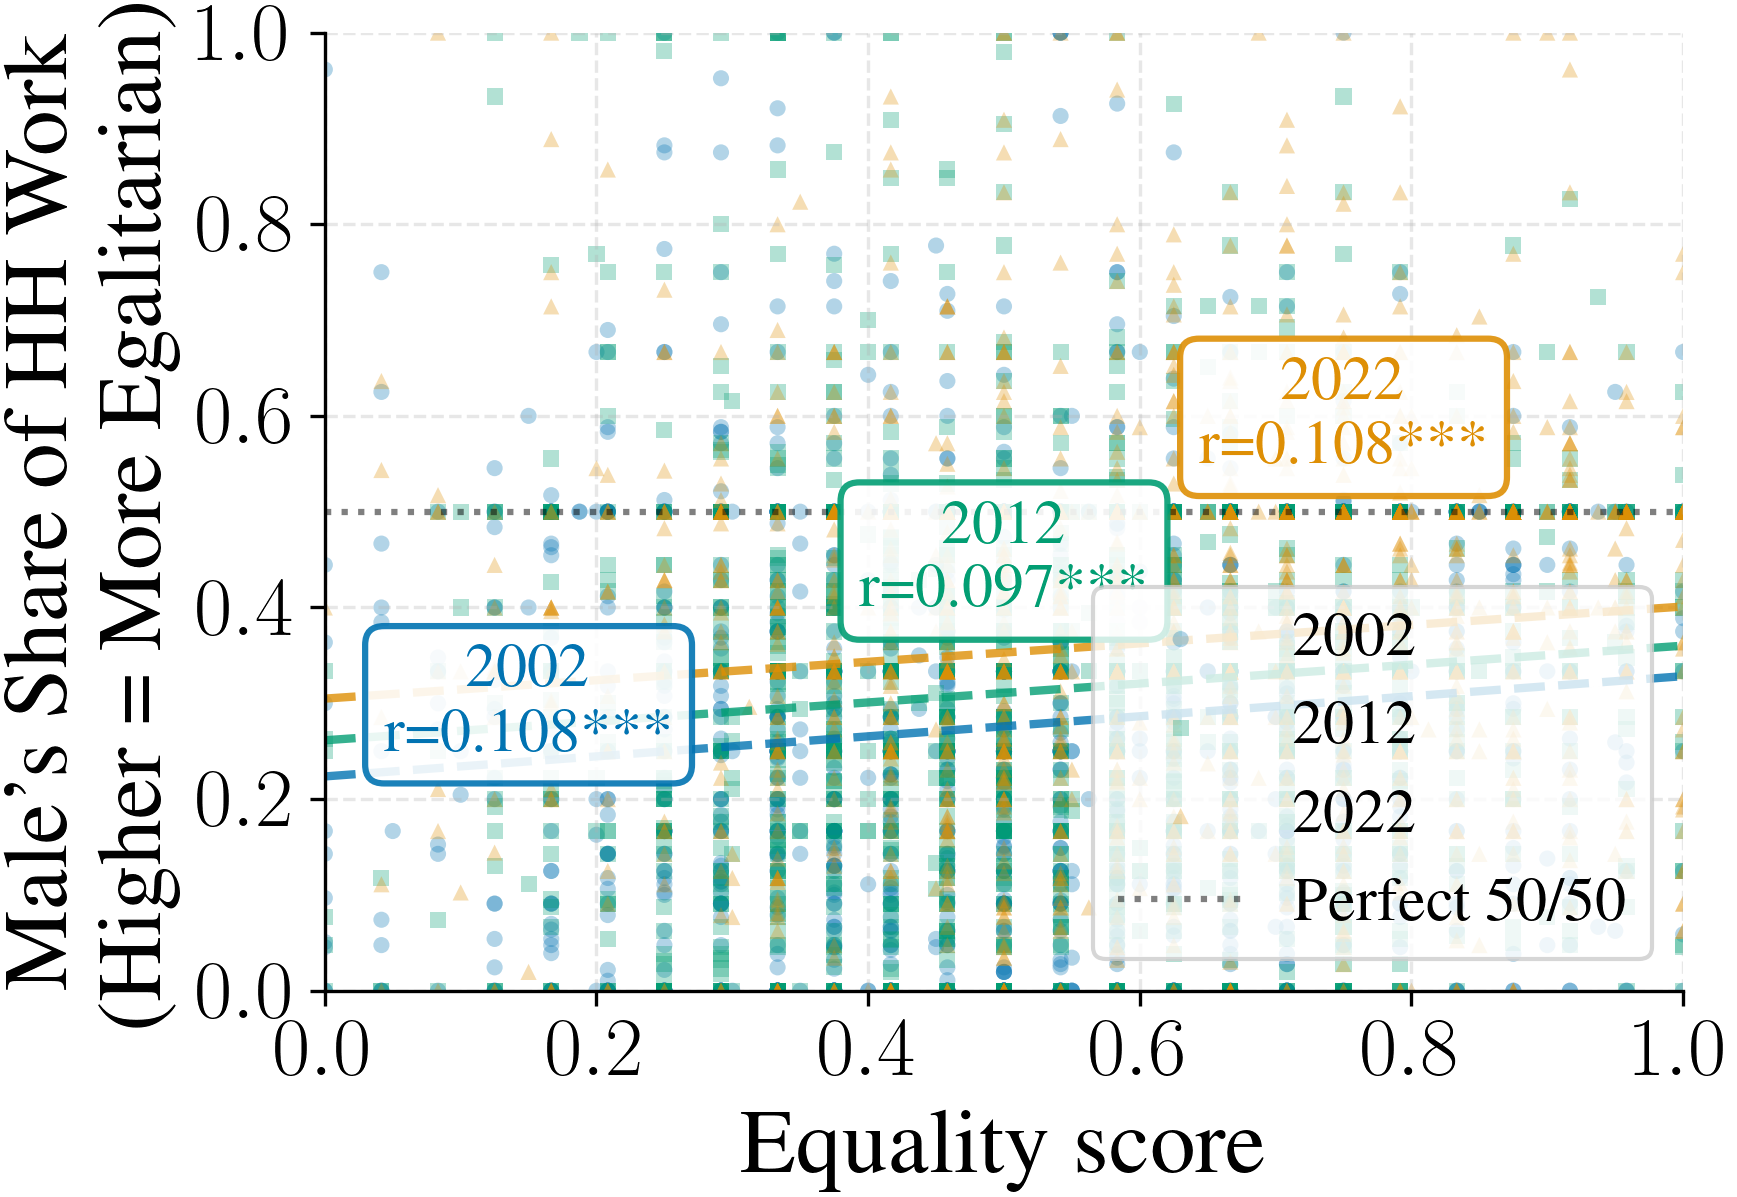

In [14]:
if USE_TUEPLOTS:
    plt.rcParams.update(bundles.icml2024())
    plt.rcParams.update(figsizes.icml2024_half(nrows=1, ncols=1))

fig, ax = plt.subplots(figsize=(6, 4.2))

colors_year = {'2002': '#0173B2', '2012': '#029E73', '2022': '#DE8F05'}
markers_year = {'2002': 'o', '2012': 's', '2022': '^'}

for year in [2002, 2012, 2022]:
    year_data = h2_data[h2_data['year'] == year]
    
    sample_size = min(1500, len(year_data))
    plot_data = year_data.sample(n=sample_size, random_state=42)
    
    ax.scatter(plot_data['eg_score_norm'], plot_data['equity_metric'],
               alpha=0.3, s=15, marker=markers_year[str(year)], 
               color=colors_year[str(year)], label=f'{year}', edgecolors='none')
    
    result = h2_df[h2_df['Year'] == year].iloc[0]
    x_line = np.linspace(0, 1, 100)
    y_line = result['Slope'] * x_line + (year_data['equity_metric'].mean() - result['Slope'] * year_data['eg_score_norm'].mean())
    ax.plot(x_line, y_line, color=colors_year[str(year)], linewidth=2, linestyle='--', alpha=0.8)
    
    text_positions = {2002: (0.15, 0.25), 2012: (0.50, 0.40), 2022: (0.75, 0.55)}
    text_x, text_y = text_positions[year]
    sig = '***' if result['Pearson_p'] < 0.001 else '**' if result['Pearson_p'] < 0.01 else '*'
    ax.text(text_x, text_y, f"{year}\nr={result['Pearson_r']:.3f}{sig}",
            fontsize=15, ha='center', color=colors_year[str(year)], fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, 
                     edgecolor=colors_year[str(year)], linewidth=1.5))

ax.axhline(y=0.5, color='black', linestyle=':', linewidth=1.5, alpha=0.5, label='Perfect 50/50')
ax.set_xlabel('Equality score', fontsize=22)
ax.set_ylabel("Male's Share of HH Work\n(Higher = More Egalitarian)", fontsize=22)
ax.legend(frameon=True, loc='lower right', fontsize=15)
ax.tick_params(axis='both', labelsize=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
os.makedirs('assets/images/statistical', exist_ok=True)
plt.savefig('assets/images/statistical/h2_attitude_behavior_clean.pdf', dpi=300, bbox_inches='tight')
plt.savefig('assets/images/statistical/h2_attitude_behavior_clean.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
def calculate_respondent_share(row):
    total_hrs = row['hh_wrk_hrs'] + row['SP_HH']
    if total_hrs == 0 or pd.isna(total_hrs):
        return np.nan
    return row['hh_wrk_hrs'] / total_hrs

analysis_data['respondent_hh_share'] = analysis_data.apply(calculate_respondent_share, axis=1)
analysis_data['respondent_hh_share'] = analysis_data['respondent_hh_share'].clip(0, 1)

print("Respondent's share of HH work (0.5 = equal, >0.5 = respondent does more)")
for sex in ['Male', 'Female']:
    sex_data = analysis_data[analysis_data['sex'] == sex]['respondent_hh_share'].dropna()
    print(f"{sex}: mean={sex_data.mean():.3f}, "
          f"{(sex_data > 0.5).sum() / len(sex_data) * 100:.1f}% do more than partner")

Respondent's share of HH work (0.5 = equal, >0.5 = respondent does more)
Male: mean=0.349, 12.7% do more than partner
Female: mean=0.712, 78.4% do more than partner


In [16]:
# Update h2_data to include respondent_hh_share
h2_data = analysis_data[['year', 'sex', 'eg_score_norm', 'equity_metric', 'respondent_hh_share']].dropna()

gender_results = []

for year in [2002, 2012, 2022]:
    year_data = h2_data[h2_data['year'] == year]
    
    male_data = year_data[year_data['sex'] == 'Male']
    male_r, male_p = pearsonr(male_data['eg_score_norm'], male_data['respondent_hh_share'])
    
    female_data = year_data[year_data['sex'] == 'Female']
    female_r, female_p = pearsonr(female_data['eg_score_norm'], female_data['respondent_hh_share'])
    
    z_stat, p_diff = fishers_z_test(male_r, len(male_data), female_r, len(female_data))
    
    gender_results.append({
        'Year': year,
        'Male_N': len(male_data),
        'Male_r': male_r,
        'Male_p': male_p,
        'Female_N': len(female_data),
        'Female_r': female_r,
        'Female_p': female_p,
        'Diff_Z': z_stat,
        'Diff_p': p_diff
    })

gender_df = pd.DataFrame(gender_results)
print("Gender-stratified correlation with respondent's HH share")
print(gender_df.to_string(index=False))

Gender-stratified correlation with respondent's HH share
 Year  Male_N   Male_r       Male_p  Female_N  Female_r     Female_p    Diff_Z  Diff_p
 2002   12539 0.118069 3.636993e-40     14907 -0.128769 3.862434e-56 20.473047     0.0
 2012   16988 0.108467 1.249736e-45     17688 -0.112901 2.854731e-51 20.689960     0.0
 2022   12305 0.139429 1.831663e-54     13284 -0.106005 1.655796e-34 19.718881     0.0


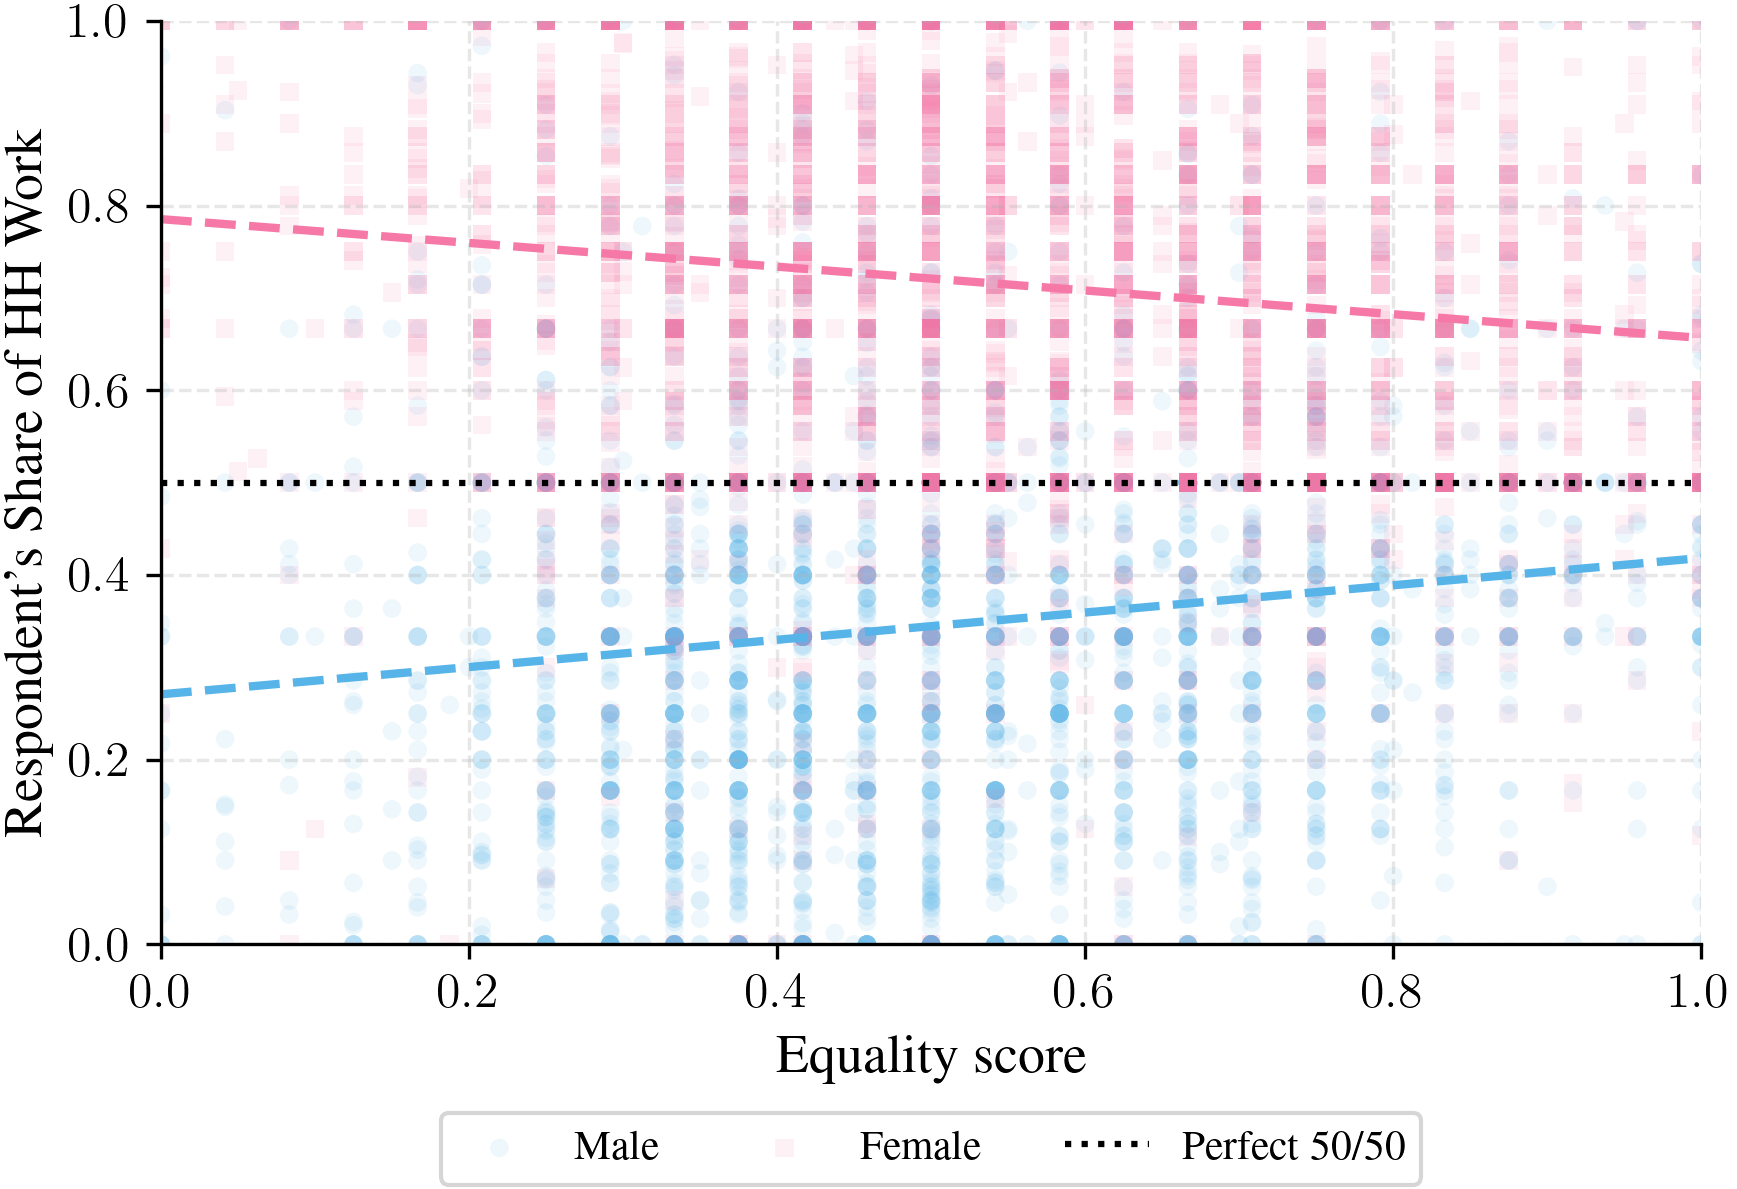

In [42]:
if USE_TUEPLOTS:
    plt.rcParams.update(bundles.icml2024())
    plt.rcParams.update(figsizes.icml2024_half(nrows=1, ncols=1))

fig, ax = plt.subplots(figsize=(6, 4.2))

# Use all years combined, not just 2022
all_years_data = h2_data

for sex in ['Male', 'Female']:
    sex_data = all_years_data[all_years_data['sex'] == sex]
    color = COLOR_PALETTE[sex]
    marker = 'o' if sex == 'Male' else 's'
    
    sample_size = min(3000, len(sex_data))  # Increased sample size for all years
    plot_data = sex_data.sample(n=sample_size, random_state=42)
    
    ax.scatter(plot_data['eg_score_norm'], plot_data['respondent_hh_share'],
               alpha=0.1, s=20, marker=marker, color=color,
               label=sex, edgecolors='none')
    
    X_sex = sex_data['eg_score_norm'].values.reshape(-1, 1)
    y_sex = sex_data['respondent_hh_share'].values
    model_sex = LinearRegression()
    model_sex.fit(X_sex, y_sex)
    
    x_line = np.linspace(0, 1, 100)
    y_line = model_sex.predict(x_line.reshape(-1, 1))
    ax.plot(x_line, y_line, color=color, linewidth=2, linestyle='--', alpha=1.0)

ax.axhline(y=0.5, color='black', linestyle=':', linewidth=1.5, alpha=1.0, label='Perfect 50/50')
ax.set_xlabel('Equality score', fontsize=13)
ax.set_ylabel("Respondent's Share of HH Work", fontsize=13)

# ax.text(0.02, 0.98, "Males: higher = egalitarian\nFemales: lower = egalitarian", 
#         transform=ax.transAxes, fontsize=13, va='top', ha='left',
#         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'))

# ax.legend(frameon=True, loc='center left', fontsize=15)
# ax.legend(frameon=True, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
ax.legend(frameon=True, loc='upper center', bbox_to_anchor=(0.5, -0.16), 
          ncol=3, fontsize=10)

# show legend outside the plot
ax.tick_params(axis='both', labelsize=12)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
os.makedirs('assets/images/statistical', exist_ok=True)
plt.savefig('assets/images/statistical/h2_gender_stratified_all_years_clean.pdf', dpi=300, bbox_inches='tight')
plt.savefig('assets/images/statistical/h2_gender_stratified_all_years_clean.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
r_squared_results = []

for year in [2002, 2012, 2022]:
    year_data = h2_data[h2_data['year'] == year]
    
    X_all = year_data['eg_score_norm'].values.reshape(-1, 1)
    y_all = year_data['respondent_hh_share'].values
    model_all = LinearRegression()
    model_all.fit(X_all, y_all)
    r2_all = model_all.score(X_all, y_all)
    
    male_data = year_data[year_data['sex'] == 'Male']
    X_male = male_data['eg_score_norm'].values.reshape(-1, 1)
    y_male = male_data['respondent_hh_share'].values
    model_male = LinearRegression()
    model_male.fit(X_male, y_male)
    r2_male = model_male.score(X_male, y_male)
    
    female_data = year_data[year_data['sex'] == 'Female']
    X_female = female_data['eg_score_norm'].values.reshape(-1, 1)
    y_female = female_data['respondent_hh_share'].values
    model_female = LinearRegression()
    model_female.fit(X_female, y_female)
    r2_female = model_female.score(X_female, y_female)
    
    r_squared_results.append({
        'Year': year,
        'N_Total': len(year_data),
        'R²_Overall': r2_all,
        'R²_Male': r2_male,
        'R²_Female': r2_female,
        'N_Male': len(male_data),
        'N_Female': len(female_data)
    })

r2_df = pd.DataFrame(r_squared_results)

X_all_years = h2_data['eg_score_norm'].values.reshape(-1, 1)
y_all_years = h2_data['respondent_hh_share'].values
model_all_years = LinearRegression()
model_all_years.fit(X_all_years, y_all_years)
r2_all_years = model_all_years.score(X_all_years, y_all_years)

male_all = h2_data[h2_data['sex'] == 'Male']
female_all = h2_data[h2_data['sex'] == 'Female']

X_male_all = male_all['eg_score_norm'].values.reshape(-1, 1)
y_male_all = male_all['respondent_hh_share'].values
model_male_all = LinearRegression()
model_male_all.fit(X_male_all, y_male_all)
r2_male_all = model_male_all.score(X_male_all, y_male_all)

X_female_all = female_all['eg_score_norm'].values.reshape(-1, 1)
y_female_all = female_all['respondent_hh_share'].values
model_female_all = LinearRegression()
model_female_all.fit(X_female_all, y_female_all)
r2_female_all = model_female_all.score(X_female_all, y_female_all)

r2_values = r2_df['R²_Overall'].values
years = r2_df['Year'].values
slope_r2, intercept_r2, r_r2, p_r2, se_r2 = linregress(years, r2_values)

print(f"R² by year: {dict(zip(r2_df['Year'], r2_df['R²_Overall']))}")
print(f"All years R²: {r2_all_years:.4f}")
print(f"Temporal trend: slope={slope_r2:.6f}, p={p_r2:.4f}")

R² by year: {2002: 0.003342964876218213, 2012: 0.0029435218110324124, 2022: 0.0028628652660612763}
All years R²: 0.0027
Temporal trend: slope=-0.000024, p=0.2331


## 5. H3: Rate of Convergence (Conditional)

**Conditional on H1 results:** If household work converges, compare the rate of convergence in behavior vs attitudes.

If H1 shows no convergence, this analysis tests whether attitudes are converging while behavior remains stable (norm-behavior divergence).

In [19]:
attitude_results = []

for year in [2002, 2012, 2022]:
    year_data = analysis_data[analysis_data['year'] == year]
    
    male_eg = year_data[year_data['sex'] == 'Male']['eg_score_norm'].dropna()
    female_eg = year_data[year_data['sex'] == 'Female']['eg_score_norm'].dropna()
    
    male_mean = male_eg.mean()
    female_mean = female_eg.mean()
    gap = female_mean - male_mean
    
    t_stat, p_value = ttest_ind(female_eg, male_eg)
    
    attitude_results.append({
        'Year': year,
        'Male_Mean': male_mean,
        'Female_Mean': female_mean,
        'Gap': gap,
        'T_Stat': t_stat,
        'P_Value': p_value
    })

attitude_df = pd.DataFrame(attitude_results)
print("Gender gap in egalitarian attitudes")
print(attitude_df.to_string(index=False))

Gender gap in egalitarian attitudes
 Year  Male_Mean  Female_Mean      Gap    T_Stat      P_Value
 2002   0.493730     0.531425 0.037695 15.052936 5.259482e-51
 2012   0.514428     0.551014 0.036586 16.584113 1.563683e-61
 2022   0.595492     0.628877 0.033385 12.329362 7.898753e-35


In [20]:
years = attitude_df['Year'].values
attitude_gaps = attitude_df['Gap'].values
behavior_gaps = h1_df['Gap'].values

slope_att, intercept_att, r_att, p_att, se_att = linregress(years, attitude_gaps)
slope_beh, intercept_beh, r_beh, p_beh, se_beh = linregress(years, behavior_gaps)

print("H3: Rate of convergence")
print(f"Attitude gap trend: slope={slope_att:.4f} pts/year, p={p_att:.4f}")
print(f"Behavior gap trend: slope={slope_beh:.4f} hrs/year, p={p_beh:.4f}")

if p_att < 0.05 and p_beh >= 0.05:
    print("Result: Attitudes converging, behavior stable → norm-behavior divergence")
elif p_beh < 0.05 and p_att >= 0.05:
    print("Result: Behavior converging, attitudes stable")
elif p_beh < 0.05 and p_att < 0.05:
    ratio = abs(slope_att / slope_beh) if slope_beh != 0 else np.inf
    print(f"Result: Both converging - attitudes change {ratio:.2f}x faster than behavior")
else:
    print("Result: Neither converging")

H3: Rate of convergence
Attitude gap trend: slope=-0.0002 pts/year, p=0.1739
Behavior gap trend: slope=-0.2971 hrs/year, p=0.0254
Result: Behavior converging, attitudes stable


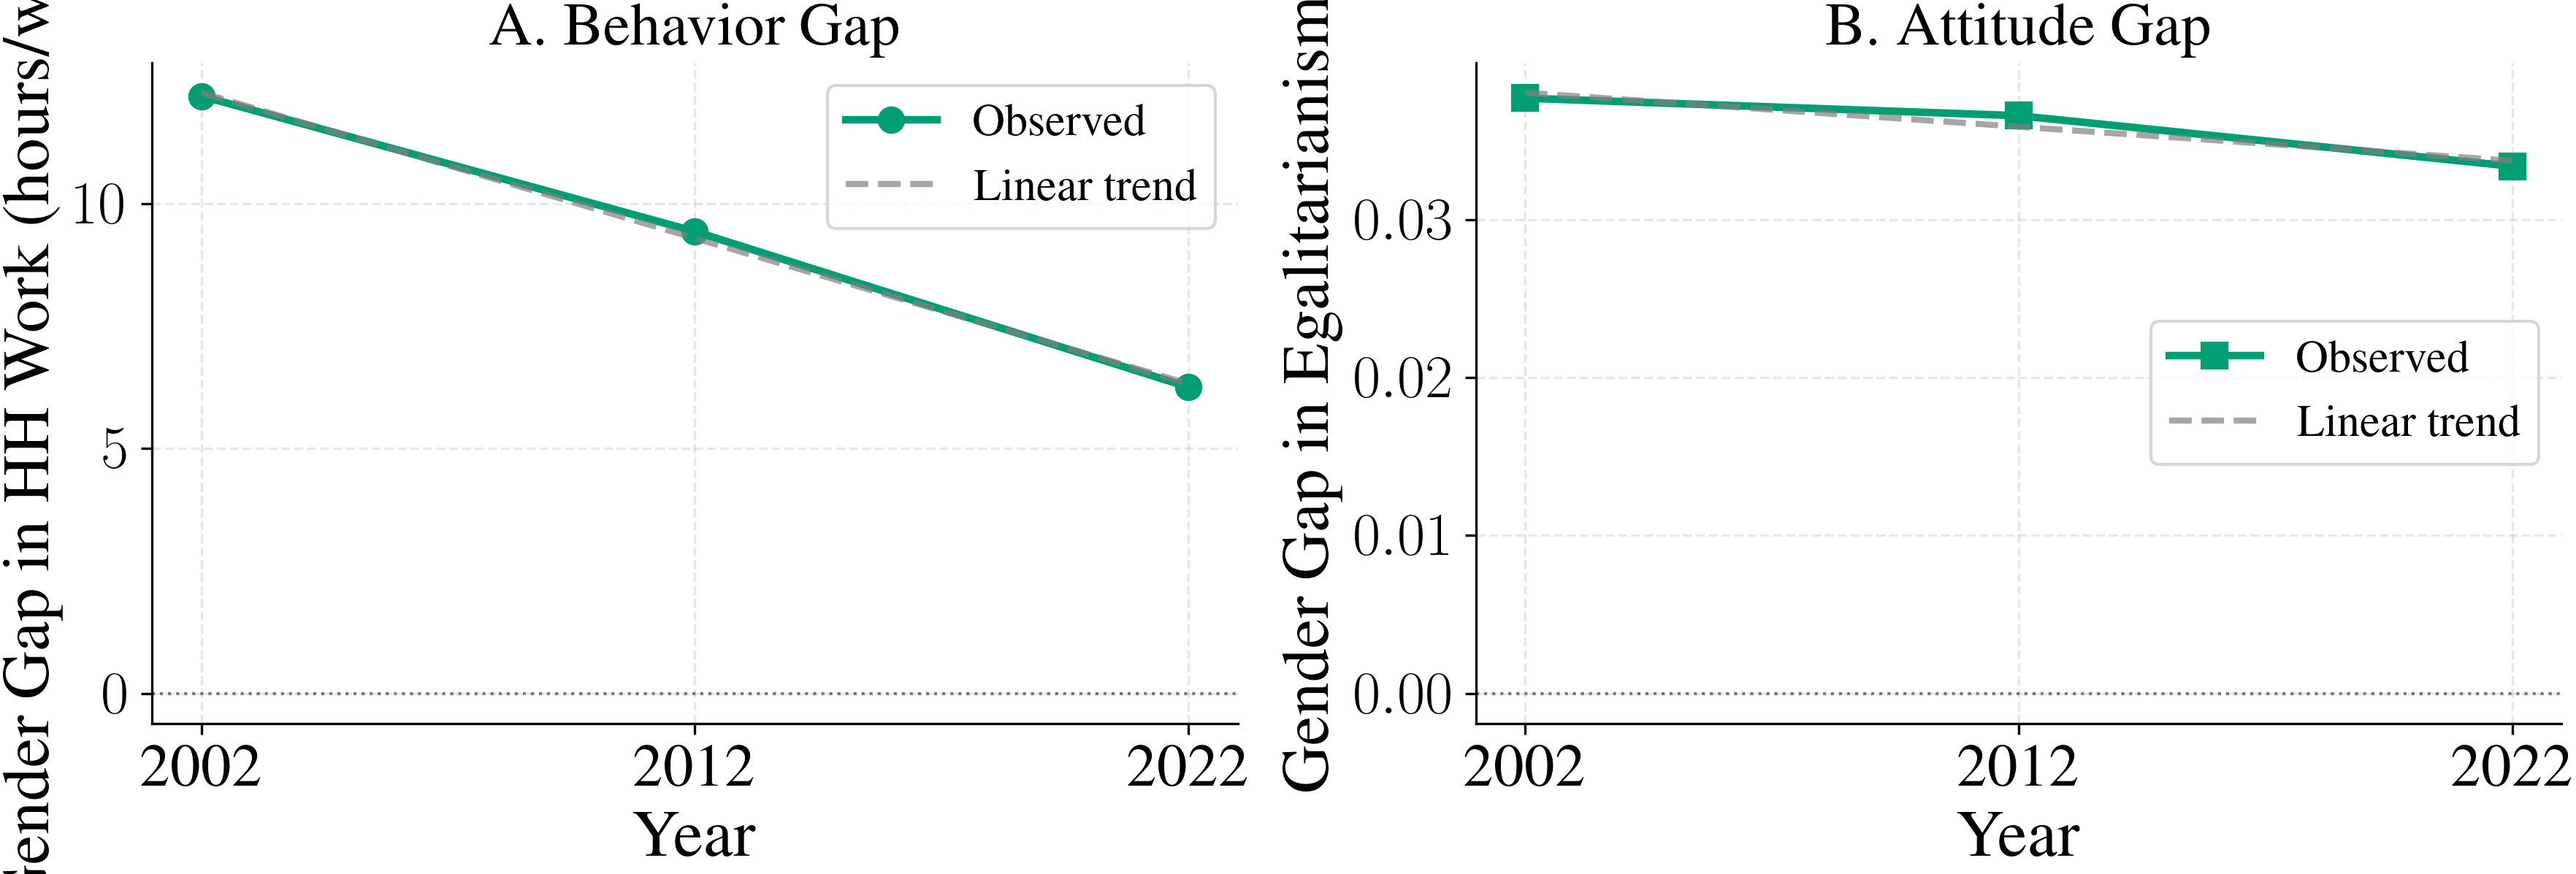

In [21]:
if USE_TUEPLOTS:
    plt.rcParams.update(bundles.icml2024())
    plt.rcParams.update(figsizes.icml2024_half(nrows=1, ncols=2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.2))

# Panel A: Behavior gaps
ax1.plot(years, behavior_gaps, marker='o', linewidth=2.5, markersize=8, 
         color=COLOR_PALETTE['neutral'], label='Observed')
ax1.plot(years, slope_beh * years + intercept_beh, linestyle='--', linewidth=2,
         color='gray', alpha=0.7, label='Linear trend')
ax1.axhline(y=0, color='black', linestyle=':', linewidth=1, alpha=0.5)
ax1.set_xlabel('Year', fontsize=22)
ax1.set_ylabel('Gender Gap in HH Work (hours/week)', fontsize=22)
ax1.set_title('A. Behavior Gap', fontweight='bold', fontsize=20)
ax1.legend(frameon=True, fontsize=15)
ax1.tick_params(axis='both', labelsize=20)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xticks([2002, 2012, 2022])
ax1.set_xticklabels(['2002', '2012', '2022'])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Panel B: Attitude gaps
ax2.plot(years, attitude_gaps, marker='s', linewidth=2.5, markersize=8,
         color=COLOR_PALETTE['neutral'], label='Observed')
ax2.plot(years, slope_att * years + intercept_att, linestyle='--', linewidth=2,
         color='gray', alpha=0.7, label='Linear trend')
ax2.axhline(y=0, color='black', linestyle=':', linewidth=1, alpha=0.5)
ax2.set_xlabel('Year', fontsize=22)
ax2.set_ylabel('Gender Gap in Egalitarianism', fontsize=22)
ax2.set_title('B. Attitude Gap', fontweight='bold', fontsize=20)
ax2.legend(frameon=True, fontsize=15)
ax2.tick_params(axis='both', labelsize=20)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xticks([2002, 2012, 2022])
ax2.set_xticklabels(['2002', '2012', '2022'])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
os.makedirs('assets/images/statistical', exist_ok=True)
plt.savefig('assets/images/statistical/h3_convergence_comparison_clean.pdf', dpi=300, bbox_inches='tight')
plt.savefig('assets/images/statistical/h3_convergence_comparison_clean.png', dpi=300, bbox_inches='tight')
plt.show()